In [1]:
import os
import re
import pickle
import string
import random
import json
import jsonlines
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from typing import *

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
def set_seeds(seed=42):
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(42)

# Utils

In [3]:
def save_pickle(data: dict, path: str) -> None:
    with open(path, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path: str) -> dict:
    with open(path, 'rb') as f:
        return pickle.load(f)

In [4]:
# Saving / loading models
class Checkpoint:
    def __init__(self, path: str, resume=False):
        self.path = path
        os.makedirs(path, exist_ok=True)
        self.resume = resume

    def load(self, model, optimizer, id_path=""):
        if (not self.resume) and id_path == "":
            raise RuntimeError()
        if self.resume:
            id_path = sorted(os.listdir(self.path))[-1]
        self.checkpoint = torch.load(
            os.path.join(self.path, id_path), map_location=lambda storage, loc: storage
        )
        if self.checkpoint == None:
            raise RuntimeError("Checkpoint empty.")
        epoch = self.checkpoint["epoch"]
        model.load_state_dict(self.checkpoint["model_state_dict"])
        optimizer.load_state_dict(self.checkpoint["optimizer_state_dict"])
        losses = self.checkpoint["losses"]
        accuracies = self.checkpoint["accuracies"]
        return (model, optimizer, epoch, losses, accuracies)

    def save(self, model, optimizer, epoch, losses, accuracies):
        model_checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "losses": losses,
            "accuracies": accuracies
        }
        checkpoint_name = "{}.pth".format(str(epoch).zfill(3))
        complete_path = os.path.join(self.path, checkpoint_name)
        torch.save(model_checkpoint, complete_path)
        return

    def load_just_model(self, model, id_path=""):
        if self.resume:
            id_path = sorted(os.listdir(self.path))[-1]
        self.checkpoint = torch.load(
            os.path.join(self.path, id_path), map_location=lambda storage, loc: storage
        )
        if self.checkpoint == None:
            raise RuntimeError("Checkpoint empty.")
        model.load_state_dict(self.checkpoint["model_state_dict"])
        return model

In [5]:
set_stopwords = set(stopwords.words())

def preprocess(sentence: str, target_word=None) -> str:
    # lowercase sentence
    sentence = sentence.lower()
    # remove punctuation
    sentence = re.sub('[^\w\s]', ' ', sentence)
    # replace multiple adjacent spaces with one single space
    sentence = re.sub(' +', ' ', sentence).strip()
    
    tokens = sentence.split()
    tokens_sw = [word for word in tokens if (not word in set_stopwords or word == target_word)]
    
    return ' '.join(tokens_sw)

In [6]:
def get_neighbourhood(tokens: List[str], target_position: int, width: int = 2) -> Tuple[List[str], int]:
    neighbourhood = []
    new_position = width
    
    for pos in range(target_position - width, target_position + width + 1):
        if pos < 0:
            new_position -= 1
            continue
        if pos >= len(tokens):
            continue
        neighbourhood.append(tokens[pos])

    return neighbourhood, new_position

In [7]:
def embeddings_dictionary(path: str, skip_first=False) -> Dict[str, torch.Tensor]:
    word_vectors = dict()
    with open(path) as f:
        for i, line in tqdm(enumerate(f)):
            
            if i == 0 and skip_first:
                continue

            word, *vector = line.strip().split(' ')
            vector = torch.tensor([float(c) for c in vector])

            word_vectors[word] = vector
    return word_vectors

# Create word embedding with GloVe

In [8]:
def custom_tokenizer(sentence: str, marker: str) -> List[str]:
    tokens = sentence.split()
    for i, tk in enumerate(tokens):
        if marker in tk:
            target_position = i
            tokens[i] = tk[20:]
    return tokens, target_position

In [9]:
class TokensEmbedder(object):
    def __init__(self, word_vectors: Dict[str, torch.Tensor]) -> None:
        self.word_vectors = word_vectors
    
    def compute_embeddings(self, tokens: List[str]) -> List[torch.Tensor]:
        word_embeddings = []
        for w in tokens:
            word_embeddings.append(self.word_vectors[w] if w in self.word_vectors else self.word_vectors['<unk>'])
        
        return word_embeddings
    
    def aggregate_embeddings(self, tokens: List[str], target_position: int) -> torch.Tensor:
        pass
    
    def __call__(self, tokens: List[str], target_position: int) -> torch.Tensor:
        return self.aggregate_embeddings(tokens, target_position)

class AverageEmbedder(TokensEmbedder):
    def __init__(self, word_vectors: Dict[str, torch.Tensor]) -> None:
        self.word_vectors = word_vectors
    
    def aggregate_embeddings(self, tokens: List[str], target_position: int) -> torch.Tensor:
        embeddings = torch.stack(self.compute_embeddings(tokens))
        return torch.mean(embeddings, dim=0)

class WeightedAverageEmbedder(TokensEmbedder):
    def __init__(self, word_vectors: Dict[str, torch.Tensor], max_weight: float = 1.0, min_weight: float = 0.0) -> None:
        self.word_vectors = word_vectors
        self.max_weight = max_weight
        self.min_weight = min_weight
    
    def aggregate_embeddings(self, tokens: List[str], target_position: int) -> torch.Tensor:
        embeddings = torch.stack(self.compute_embeddings(tokens))
        # aliases for readibility
        n = len(embeddings)
        t = target_position

        # weights from 1 to 0
        weights = torch.linspace(self.max_weight, self.min_weight, n).unsqueeze(1)
        # weights = torch.exp(reversed(torch.arange(n, dtype=torch.float32))).unsqueeze(1)

        # weighted vector
        new_vectors = embeddings

        # weighted average

        # right of the target word
        new_vectors[t:] = new_vectors[t:] * weights[:n - t]
        # left of the target word
        new_vectors[:t] = new_vectors[:t] * reversed(weights[1:t + 1])

        # denominator (sum of the weights)
        weights_sum = weights[:n - t].sum() + weights[1:t + 1].sum()

        return new_vectors.sum(dim=0) / weights_sum

In [10]:
embedding_path = 'embeddings/glove.6B.300d.txt'
# embedding_path = 'embeddings/GoogleNews-vectors-negative300.txt'

word_vectors = embeddings_dictionary(embedding_path, skip_first=False)

# <unk> token
# https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
# unk_embedding = '0.22418134 -0.28881392 0.13854356 0.00365387 -0.12870757 0.10243822 0.061626635 0.07318011 -0.061350107 -1.3477012 0.42037755 -0.063593924 -0.09683349 0.18086134 0.23704372 0.014126852 0.170096 -1.1491593 0.31497982 0.06622181 0.024687296 0.076693475 0.13851812 0.021302193 -0.06640582 -0.010336159 0.13523154 -0.042144544 -0.11938788 0.006948221 0.13333307 -0.18276379 0.052385733 0.008943111 -0.23957317 0.08500333 -0.006894406 0.0015864656 0.063391194 0.19177166 -0.13113557 -0.11295479 -0.14276934 0.03413971 -0.034278486 -0.051366422 0.18891625 -0.16673574 -0.057783455 0.036823478 0.08078679 0.022949161 0.033298038 0.011784158 0.05643189 -0.042776518 0.011959623 0.011552498 -0.0007971594 0.11300405 -0.031369694 -0.0061559738 -0.009043574 -0.415336 -0.18870236 0.13708843 0.005911723 -0.113035575 -0.030096142 -0.23908928 -0.05354085 -0.044904727 -0.20228513 0.0065645403 -0.09578946 -0.07391877 -0.06487607 0.111740574 -0.048649278 -0.16565254 -0.052037314 -0.078968436 0.13684988 0.0757494 -0.006275573 0.28693774 0.52017444 -0.0877165 -0.33010918 -0.1359622 0.114895485 -0.09744406 0.06269521 0.12118575 -0.08026362 0.35256687 -0.060017522 -0.04889904 -0.06828978 0.088740796 0.003964443 -0.0766291 0.1263925 0.07809314 -0.023164088 -0.5680669 -0.037892066 -0.1350967 -0.11351585 -0.111434504 -0.0905027 0.25174105 -0.14841858 0.034635577 -0.07334565 0.06320108 -0.038343467 -0.05413284 0.042197507 -0.090380974 -0.070528865 -0.009174437 0.009069661 0.1405178 0.02958134 -0.036431845 -0.08625681 0.042951006 0.08230793 0.0903314 -0.12279937 -0.013899368 0.048119213 0.08678239 -0.14450377 -0.04424887 0.018319942 0.015026873 -0.100526 0.06021201 0.74059093 -0.0016333034 -0.24960588 -0.023739101 0.016396184 0.11928964 0.13950661 -0.031624354 -0.01645025 0.14079992 -0.0002824564 -0.08052984 -0.0021310581 -0.025350995 0.086938225 0.14308536 0.17146006 -0.13943303 0.048792403 0.09274929 -0.053167373 0.031103406 0.012354865 0.21057427 0.32618305 0.18015954 -0.15881181 0.15322933 -0.22558987 -0.04200665 0.0084689725 0.038156632 0.15188617 0.13274793 0.113756925 -0.095273495 -0.049490947 -0.10265804 -0.27064866 -0.034567792 -0.018810693 -0.0010360252 0.10340131 0.13883452 0.21131058 -0.01981019 0.1833468 -0.10751636 -0.03128868 0.02518242 0.23232952 0.042052146 0.11731903 -0.15506615 0.0063580726 -0.15429358 0.1511722 0.12745973 0.2576985 -0.25486213 -0.0709463 0.17983761 0.054027 -0.09884228 -0.24595179 -0.093028545 -0.028203879 0.094398156 0.09233813 0.029291354 0.13110267 0.15682974 -0.016919162 0.23927948 -0.1343307 -0.22422817 0.14634751 -0.064993896 0.4703685 -0.027190214 0.06224946 -0.091360025 0.21490277 -0.19562101 -0.10032754 -0.09056772 -0.06203493 -0.18876675 -0.10963594 -0.27734384 0.12616494 -0.02217992 -0.16058226 -0.080475815 0.026953284 0.110732645 0.014894041 0.09416802 0.14299914 -0.1594008 -0.066080004 -0.007995227 -0.11668856 -0.13081996 -0.09237365 0.14741232 0.09180138 0.081735 0.3211204 -0.0036552632 -0.047030564 -0.02311798 0.048961394 0.08669574 -0.06766279 -0.50028914 -0.048515294 0.14144728 -0.032994404 -0.11954345 -0.14929578 -0.2388355 -0.019883996 -0.15917352 -0.052084364 0.2801028 -0.0029121689 -0.054581646 -0.47385484 0.17112483 -0.12066923 -0.042173345 0.1395337 0.26115036 0.012869649 0.009291686 -0.0026459037 -0.075331464 0.017840583 -0.26869613 -0.21820338 -0.17084768 -0.1022808 -0.055290595 0.13513643 0.12362477 -0.10980586 0.13980341 -0.20233242 0.08813751 0.3849736 -0.10653763 -0.06199595 0.028849555 0.03230154 0.023856193 0.069950655 0.19310954 -0.077677034 -0.144811'
# unk_embedding = unk_embedding.strip().split()
# word_vectors['<unk>'] = torch.tensor([float(c) for c in unk_embedding])
word_vectors['<unk>'] = torch.rand(300)

0it [00:00, ?it/s]

In [10]:
# save_pickle(word_vectors, 'embeddings/vocabulary_tensors.pkl')

# Dataset class using GloVe

In [14]:
class EmbeddedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str, marker: str, embedder: TokensEmbedder, neigh_width: Optional[int] = None) -> None:
        self.data = []
        self.marker = marker
        self.embedder = embedder
        self.neigh_width = neigh_width

        self.create_dataset(dataset_path)
        
    
    def create_dataset(self, dataset_path: str) -> None:
        with jsonlines.open(dataset_path, 'r') as f:
            for i, line in enumerate(f.iter()):
                # load sentences
                start1 = int(line['start1'])
                start2 = int(line['start2'])
                s1 = line['sentence1']
                s2 = line['sentence2']
                # insert special characters to locate target word after preprocessing
                s1 = s1[:start1] + self.marker + s1[start1:]
                s2 = s2[:start2] + self.marker + s2[start2:]
                
                # preprocessing
                s1 = preprocess(s1)
                s2 = preprocess(s2)
                
                # tokenization
                t1, target_position1 = custom_tokenizer(s1, self.marker)
                t2, target_position2 = custom_tokenizer(s2, self.marker)
                
                # if specified, get neighbourhood of target words
                # and recompute target position
                if self.neigh_width:
                    t1, target_position1 = get_neighbourhood(t1, target_position1, self.neigh_width)
                    t2, target_position2 = get_neighbourhood(t2, target_position2, self.neigh_width)
                
                # convert tokens to embeddings and aggregate
                v1 = self.embedder(t1, target_position1)
                v2 = self.embedder(t2, target_position2)
                
                # concatenate vectors
                sentence_vector = torch.cat((v1, v2))
                
                label = torch.tensor(1, dtype=torch.float32) if line['label'] == 'True' else torch.tensor(0, dtype=torch.float32)
                self.data.append((sentence_vector, label))


    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]

# Model Class

In [15]:
class MLP(nn.Module):
    def __init__(
        self,
        n_features: int,
        num_layers: int,
        hidden_dim: int,
        activation: Callable[[torch.Tensor], torch.Tensor],
    ) -> None:
        super().__init__()

        self.first_layer = nn.Linear(in_features=n_features, out_features=hidden_dim)

        self.layers = (
            nn.ModuleList()
        )

        for i in range(num_layers):
            self.layers.append(
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
            )
            
        self.activation = activation
        self.dropout = nn.Dropout(0.5)
        
        self.last_layer = nn.Linear(in_features=hidden_dim, out_features=1)
        
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x

        out = self.first_layer(
            out
        )  # First linear layer, transforms the hidden dimensions from `n_features` (embedding dimension) to `hidden_dim`
        for layer in self.layers:  # Apply `k` (linear, activation) layer
            out = layer(out)
            out = self.activation(out)
            out = self.dropout(out)
        out = self.last_layer(
            out
        )  # Last linear layer to bring the `hiddem_dim` features to a binary space (`True`/`False`)
        
        out = self.sigmoid(out)
        return out.squeeze(-1)


# Training process

In [16]:
def batch_to_device(batch: List[torch.Tensor], device: str) -> List[torch.Tensor]:
    return [x.to(device) for x in batch]

def fit(
    epochs: int,
    model: nn.Module,
    criterion: nn.Module,
    opt: torch.optim.Optimizer,
    train_dl: torch.utils.data.DataLoader,
    valid_dl: torch.utils.data.DataLoader,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    checkpoint: Optional[Checkpoint] = None,
    verbose: int = 2,
) -> None:

    # keep track of losses and accuracies
    losses = {"train": [], "val": []}
    accuracies = {"train": [], "val": []}
    
    if verbose > 0:
        print("Starting training.")

    # training loop
    for epoch in range(1, epochs + 1):
        # instantiate loss and accuracy each epoch
        losses_train = 0
        d_train, n_train = 0, 0

        model.train()
        train_iterator = tqdm(
            train_dl, desc=f"Epoch {epoch}/{epochs} (TRAIN)", leave=False
        ) if verbose > 1 else train_dl
        for batch in train_iterator:
            # send batch to device
            batch = batch_to_device(batch, device)
            batch_x = batch[:-1]
            batch_y = batch[-1]

            pred = model(*batch_x)

            # compute loss and backprop
            loss_train = criterion(pred, batch_y)
            loss_train.backward()
            opt.step()
            opt.zero_grad()
            losses_train += loss_train.item()

            pred = torch.round(pred)
            # number of predictions
            d_train += pred.shape[0]
            # number of correct predictions
            n_train += (batch_y == pred).int().sum().item()

        model.eval()
        with torch.no_grad():
            losses_val = 0
            d_val, n_val = 0, 0

            valid_iterator = tqdm(
                valid_dl, desc=f"Epoch {epoch}/{epochs} (VALID)", leave=False
            ) if verbose > 1 else valid_dl
            for batch in valid_iterator:
                # send batch to device
                batch = batch_to_device(batch, device)
                batch_x = batch[:-1]
                batch_y = batch[-1]

                # compute predictions
                pred_val = model(*batch_x)

                # compute loss (validation step => no backprop)
                loss_val = criterion(pred_val, batch_y)
                losses_val += loss_val.item()

                pred_val = torch.round(pred_val)
                # number of predictions
                d_val += pred_val.shape[0]
                # number of correct predictions
                n_val += (batch_y == pred_val).int().sum().item()

        # compute accuracy (train + val)
        loss_train = losses_train / d_train
        loss_val = losses_val / d_val

        acc_train = n_train / d_train
        acc_val = n_val / d_val

        # log losses and accuracies
        losses["train"].append(loss_train)
        losses["val"].append(loss_val)

        accuracies["train"].append(acc_train)
        accuracies["val"].append(acc_val)
    
        if scheduler:
            scheduler.step()
        
        # store checkpoint
        if checkpoint:
            checkpoint.save(model, opt, epoch, losses, accuracies)
        
        if verbose > 1:
            print(
                f"Epoch {epoch} \t T. Loss = {loss_train:.4f}, V. Loss = {loss_val:.4f}, T. Accuracy {acc_train:.3f}, V. Accuracy {acc_val:.3f}."
            )
    
    if verbose > 0:
        print("Training finished.")
    return losses, accuracies

In [33]:
train_path = 'data/train.jsonl'
dev_path = 'data/dev.jsonl'

random.seed(42)
marker = ''.join(random.choices(string.ascii_lowercase, k=20))

embedder = WeightedAverageEmbedder(word_vectors, 1, 0)
# embedder = AverageEmbedder(word_vectors)

train_dataset = EmbeddedDataset(train_path, marker, embedder, None)
val_dataset = EmbeddedDataset(dev_path, marker, embedder, None)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCELoss()

model = MLP(n_features=600,
            num_layers=3, 
            hidden_dim=2048, 
            activation=torch.nn.functional.relu).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00000)

checkpoint = Checkpoint(path='checkpoints/mlp')

epochs = 15


set_seeds()
losses, accuracies = fit(epochs, model, criterion, optimizer, train_loader, val_loader, checkpoint=None)

Starting training.


Epoch 1/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 	 T. Loss = 0.0055, V. Loss = 0.0055, T. Accuracy 0.509, V. Accuracy 0.563.


Epoch 2/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 	 T. Loss = 0.0054, V. Loss = 0.0054, T. Accuracy 0.544, V. Accuracy 0.583.


Epoch 3/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 	 T. Loss = 0.0052, V. Loss = 0.0052, T. Accuracy 0.596, V. Accuracy 0.625.


Epoch 4/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 	 T. Loss = 0.0049, V. Loss = 0.0050, T. Accuracy 0.656, V. Accuracy 0.637.


Epoch 5/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 	 T. Loss = 0.0045, V. Loss = 0.0050, T. Accuracy 0.703, V. Accuracy 0.663.


Epoch 6/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 	 T. Loss = 0.0040, V. Loss = 0.0051, T. Accuracy 0.759, V. Accuracy 0.666.


Epoch 7/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 	 T. Loss = 0.0034, V. Loss = 0.0056, T. Accuracy 0.806, V. Accuracy 0.649.


Epoch 8/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 	 T. Loss = 0.0028, V. Loss = 0.0059, T. Accuracy 0.852, V. Accuracy 0.656.


Epoch 9/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 	 T. Loss = 0.0022, V. Loss = 0.0065, T. Accuracy 0.883, V. Accuracy 0.652.


Epoch 10/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 	 T. Loss = 0.0016, V. Loss = 0.0075, T. Accuracy 0.918, V. Accuracy 0.652.


Epoch 11/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 	 T. Loss = 0.0014, V. Loss = 0.0078, T. Accuracy 0.931, V. Accuracy 0.673.


Epoch 12/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 	 T. Loss = 0.0010, V. Loss = 0.0095, T. Accuracy 0.956, V. Accuracy 0.649.


Epoch 13/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 	 T. Loss = 0.0008, V. Loss = 0.0093, T. Accuracy 0.964, V. Accuracy 0.677.


Epoch 14/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 	 T. Loss = 0.0007, V. Loss = 0.0105, T. Accuracy 0.970, V. Accuracy 0.655.


Epoch 15/15 (TRAIN):   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/15 (VALID):   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 	 T. Loss = 0.0005, V. Loss = 0.0115, T. Accuracy 0.976, V. Accuracy 0.651.
Training finished.


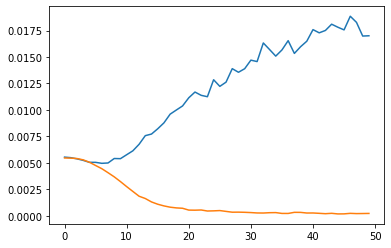

In [137]:
plt.plot(losses['val'])
plt.plot(losses['train'])

# Reccurent Neural Networks

In [34]:
def index_dictionary(word_vectors):
    word_index = dict()
    vectors_store = []

    # pad token, index = 0
    vectors_store.append(torch.rand(300))

    # unk token, index = 1
    vectors_store.append(torch.rand(300))

    # save index for each word
    for word, vector in word_vectors.items():
        # skip unk token if present
        if word == '<unk>':
            continue
        word_index[word] = len(vectors_store)
        vectors_store.append(vector)

    word_index = defaultdict(lambda: 1, word_index)  # default dict returns 1 (unk token) when unknown word
    vectors_store = torch.stack(vectors_store)
    return word_index, vectors_store

In [35]:
def tokens2indices(tokens: List[str]) -> torch.Tensor:
    return torch.tensor([word_index[word] for word in tokens], dtype=torch.long)

In [36]:
def rnn_collate_fn(
    data_elements: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]] # list of (x, y) pairs
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    X1 = [el[0] for el in data_elements]  # list of index tensors
    X2 = [el[1] for el in data_elements]  # list of index tensors

    # sizes of the sentences
    # to implement the many-to-one strategy
    X1_lengths = torch.tensor([x.size(0) for x in X1], dtype=torch.long)
    X2_lengths = torch.tensor([x.size(0) for x in X2], dtype=torch.long)

    X1 = torch.nn.utils.rnn.pad_sequence(X1, batch_first=True, padding_value=0)  #  shape (batch_size x max_seq_len)
    X2 = torch.nn.utils.rnn.pad_sequence(X2, batch_first=True, padding_value=0)  #  shape (batch_size x max_seq_len)

    y = [el[2] for el in data_elements]
    y = torch.tensor(y)

    return X1, X1_lengths, X2, X2_lengths, y

In [40]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vectors_store: torch.Tensor,
        n_hidden: int
    ) -> None:
        super().__init__()

        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(vectors_store) # (batch_size * seq_length, emb_size)

        # recurrent layer
        self.rnn = torch.nn.LSTM(input_size=vectors_store.size(1), hidden_size=n_hidden,
                                 num_layers=2, batch_first=True, bidirectional=True,
                                 dropout=0.3,
                                )

        # classification head

        self.lin1 = torch.nn.Linear(2 * (2 * n_hidden), 2 * (2 * n_hidden))
        self.lin2 = torch.nn.Linear(2 * (2 * n_hidden), 1)

        self.dropout = nn.Dropout(0.3)

        self.sigmoid = nn.Sigmoid()

        
    def _compute_embedding(self, X, X_length):
        # embedding words from indices
        embedding_out = self.embedding(X)

        # recurrent encoding
        recurrent_out = self.rnn(embedding_out)[0]
        # here we utilize the sequences length to retrieve the last token 
        # output for each sequence
        batch_size, seq_len, hidden_size = recurrent_out.shape

        # we flatten the recurrent output
        # now I have a long sequence of (batch * seq_len) vectors 
        flattened_out = recurrent_out.reshape(-1, hidden_size)
        
        # and we use a simple trick to compute a tensor of the indices 
        # of the last token in each batch element
        last_word_relative_indices = X_length - 1
        # tensor of the start offsets of each element in the batch
        sequences_offsets = torch.arange(batch_size, device=X.device) * seq_len
        # e.g. (0, 5, 10, 15, ) + ( 3, 2, 1, 4 ) = ( 3, 7, 11, 19 )
        summary_vectors_indices = sequences_offsets + last_word_relative_indices

        # finally we retrieve the vectors that should summarize every review.
        # (i.e. the last token in the sequence)
        summary_vectors = flattened_out[summary_vectors_indices]
        return summary_vectors
    
    
    def forward(
        self, 
        X1: torch.Tensor,
        X1_length: torch.Tensor,
        X2: torch.Tensor,
        X2_length: torch.Tensor,
    ) -> torch.Tensor:
        
        summary_vectors_1 = self._compute_embedding(X1, X1_length)
        summary_vectors_2 = self._compute_embedding(X2, X2_length)
        
        summary_vectors = torch.cat((summary_vectors_1, summary_vectors_2), dim=1)
        
        # now we can classify the reviews with a feedforward pass on the summary
        # vectors
        out = self.lin1(summary_vectors)
        out = torch.relu(out)
        out = self.dropout(out)
        
        out = self.lin2(out).squeeze(1)
        logits = out
        pred = self.sigmoid(logits)

        return pred

In [38]:
class IndicesDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str, marker, neigh_width = None):
        self.data = []
        self.marker = marker
        self.neigh_width = neigh_width

        self.create_dataset(dataset_path)
        
    
    def create_dataset(self, dataset_path: str) -> None:
        with jsonlines.open(dataset_path, 'r') as f:
            for i, line in enumerate(f.iter()):
                # load sentences
                start1 = int(line['start1'])
                start2 = int(line['start2'])
                end1 = int(line['end1'])
                end2 = int(line['end2'])
                s1 = line['sentence1']
                s2 = line['sentence2']
                lemma1 = s1[start1:end1]
                lemma2 = s2[start2:end2]
                
                # insert special characters to locate target word after preprocessing
                s1 = s1[:start1] + self.marker + s1[start1:]
                s2 = s2[:start2] + self.marker + s2[start2:]
                
                # preprocessing
                s1 = preprocess(s1)
                s2 = preprocess(s2)
                
                # tokenization
                t1, target_position1 = custom_tokenizer(s1, self.marker)
                t2, target_position2 = custom_tokenizer(s2, self.marker)
                
                # get neighbourhood of words
                if self.neigh_width:
                    t1, target_position1 = get_neighbourhood(t1, target_position1, self.neigh_width)
                    t2, target_position2 = get_neighbourhood(t2, target_position2, self.neigh_width)

                # sentences to indices
                i1 = tokens2indices(t1)
                i2 = tokens2indices(t2)

                label = torch.tensor(1, dtype=torch.float32) if line['label'] == 'True' else torch.tensor(0, dtype=torch.float32)
                self.data.append((i1, i2, label))


    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]

In [42]:
train_path = 'data/train.jsonl'
dev_path = 'data/dev.jsonl'

word_index, vectors_store = index_dictionary(word_vectors)

marker = ''.join(random.choices(string.ascii_lowercase, k=20))

train_dataset = IndicesDataset(train_path, marker, None)
val_dataset = IndicesDataset(dev_path, marker, None)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=rnn_collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=rnn_collate_fn)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCELoss()

model = LSTMClassifier(vectors_store, 512).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

checkpoint = Checkpoint(path='checkpoints/rnn')

epochs = 20

set_seeds()
losses, accuracies = fit(epochs, model, criterion, optimizer, train_loader, val_loader, None)

Starting training.


Epoch 1/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 	 T. Loss = 0.0217, V. Loss = 0.0221, T. Accuracy 0.504, V. Accuracy 0.545.


Epoch 2/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 	 T. Loss = 0.0216, V. Loss = 0.0216, T. Accuracy 0.535, V. Accuracy 0.607.


Epoch 3/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 	 T. Loss = 0.0205, V. Loss = 0.0206, T. Accuracy 0.602, V. Accuracy 0.630.


Epoch 4/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 	 T. Loss = 0.0198, V. Loss = 0.0202, T. Accuracy 0.635, V. Accuracy 0.648.


Epoch 5/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 	 T. Loss = 0.0191, V. Loss = 0.0208, T. Accuracy 0.654, V. Accuracy 0.629.


Epoch 6/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 	 T. Loss = 0.0186, V. Loss = 0.0210, T. Accuracy 0.669, V. Accuracy 0.622.


Epoch 7/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 	 T. Loss = 0.0180, V. Loss = 0.0217, T. Accuracy 0.691, V. Accuracy 0.610.


Epoch 8/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 	 T. Loss = 0.0174, V. Loss = 0.0218, T. Accuracy 0.710, V. Accuracy 0.628.


Epoch 9/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 	 T. Loss = 0.0165, V. Loss = 0.0232, T. Accuracy 0.731, V. Accuracy 0.617.


Epoch 10/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 	 T. Loss = 0.0158, V. Loss = 0.0232, T. Accuracy 0.753, V. Accuracy 0.634.


Epoch 11/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 	 T. Loss = 0.0150, V. Loss = 0.0255, T. Accuracy 0.765, V. Accuracy 0.602.


Epoch 12/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 	 T. Loss = 0.0140, V. Loss = 0.0243, T. Accuracy 0.794, V. Accuracy 0.605.


Epoch 13/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 	 T. Loss = 0.0130, V. Loss = 0.0262, T. Accuracy 0.809, V. Accuracy 0.591.


Epoch 14/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 	 T. Loss = 0.0119, V. Loss = 0.0283, T. Accuracy 0.835, V. Accuracy 0.578.


Epoch 15/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 	 T. Loss = 0.0108, V. Loss = 0.0299, T. Accuracy 0.850, V. Accuracy 0.589.


Epoch 16/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 	 T. Loss = 0.0096, V. Loss = 0.0336, T. Accuracy 0.871, V. Accuracy 0.604.


Epoch 17/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 	 T. Loss = 0.0086, V. Loss = 0.0373, T. Accuracy 0.885, V. Accuracy 0.586.


Epoch 18/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 	 T. Loss = 0.0072, V. Loss = 0.0382, T. Accuracy 0.910, V. Accuracy 0.603.


Epoch 19/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 	 T. Loss = 0.0064, V. Loss = 0.0427, T. Accuracy 0.919, V. Accuracy 0.590.


Epoch 20/20 (TRAIN):   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20/20 (VALID):   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 	 T. Loss = 0.0053, V. Loss = 0.0500, T. Accuracy 0.935, V. Accuracy 0.591.
Training finished.
